## Installing dependencies

In [1]:
#!pip install yfinance --upgrade --no-cache-dir
#!pip install pandas-datareader
#!pip install fix-yahoo-finance

## Importing libraries

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

## Uploading the data from Yahoo Finance

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf

df = pdr.DataReader("DIS", start='2010-01-01', end='2018-01-01', data_source='yahoo')

## Looking at the data

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,32.750000,31.870001,32.50,32.070000,13700400.0,28.101282
2010-01-05,32.160000,31.700001,32.07,31.990000,10307700.0,28.031176
2010-01-06,32.000000,31.680000,31.90,31.820000,10709500.0,27.882219
2010-01-07,31.860001,31.540001,31.77,31.830000,8202100.0,27.890982
2010-01-08,31.940001,31.530001,31.66,31.879999,7657500.0,27.934788


In [5]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-12-26,109.370003,107.889999,108.489998,108.120003,3982400.0,105.777199
2017-12-27,108.550003,107.459999,108.419998,107.639999,5624000.0,105.307602
2017-12-28,108.050003,107.059998,108.000000,107.769997,3477700.0,105.434784
2017-12-29,108.339996,107.510002,108.050003,107.510002,4538400.0,105.180420
2018-01-02,111.809998,108.559998,108.949997,111.800003,11014300.0,109.377464


C:\Users\SOS Monitoria\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


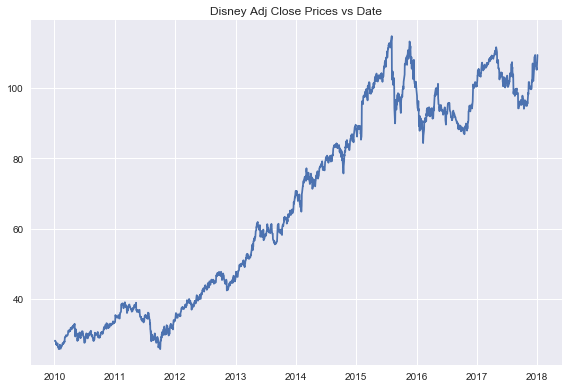

In [6]:
plt.style.use('seaborn')
plt.plot(df['Adj Close'])
plt.title('Disney Adj Close Prices vs Date')
plt.tight_layout()
plt.show()

## Feature Engineering

In [7]:
dfreg = df.loc[:, ['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High']-df['Low']) / df['Close']*100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100

## Pre-processing


### Steps:

1) Drop missing values;

2) Separate training and testing sets.

3) Selecting the label we want to predict;

4) Rescale X

5) X data series for model generating and evaluation;

6) Separate y label;

In [8]:
#1) Drop missing values;

dfreg.fillna(value=-99999, inplace = True)

# 2) Separate training and testing sets.

forecast_out = int(math.ceil(0.01 * len(dfreg)))

# 3) Selecting the label we want to predict;

forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# 4) Rescale X

X = scale(X)

# 5) X data series for model generating and evaluation;

X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# 6) Separate y label;

y = np.array(dfreg['label'])
y = y[:-forecast_out]

## Creating and training Linear, Quadratic regression and KNN models

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Linear Regression
lreg = LinearRegression(n_jobs=-1)
lreg.fit(X_train, y_train)

#Quadratic Regression (2nd order)

clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regresion (3rd order)
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

## Evaluating the models

In [10]:
lreg_score = lreg.score(X_test, y_test)
poly2_score = clfpoly2.score(X_test, y_test)
poly3_score = clfpoly3.score(X_test, y_test)
knn_score = clfknn.score(X_test, y_test)

print(f'Linear Regression score: {lreg_score}')
print(f'Quadratic 2 score: {poly2_score}')
print(f'Quadratic 3 score: {poly3_score}')
print(f'KNN score: {knn_score}')

Linear Regression score: 0.9795667785917701
Quadratic 2 score: 0.980973924602292
Quadratic 3 score: 0.9810377897841244
KNN score: 0.9621925684511835


# Plotting prediction graphs

In [68]:
forecast_lreg = lreg.predict(X_lately)
forecast_poly2 = clfpoly2.predict(X_lately)
forecast_poly3 = clfpoly3.predict(X_lately)
forecast_knn = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

## Linear Regression

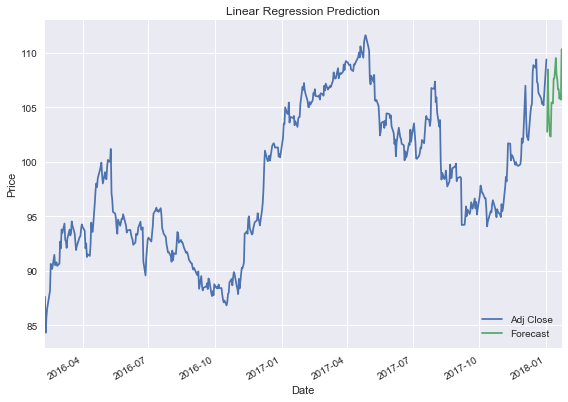

In [67]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

dfreg2 = dfreg.copy()

for i in forecast_lreg:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg2.loc[next_date] = [np.nan for _ in range(len(dfreg2.columns)-1)]+[i]
dfreg2['Adj Close'].tail(500).plot()
dfreg2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.title('Linear Regression Prediction')
plt.show()

## Quadratic polynomial 2

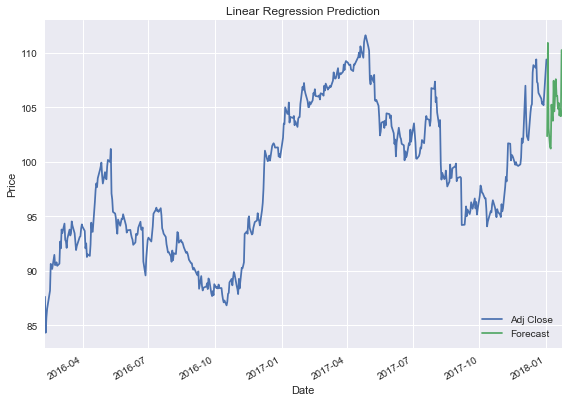

In [66]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

dfreg2 = dfreg.copy()

for i in forecast_poly2:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg2.loc[next_date] = [np.nan for _ in range(len(dfreg2.columns)-1)]+[i]
dfreg2['Adj Close'].tail(500).plot()
dfreg2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.title('Linear Regression Prediction')
plt.show()

## Quadratic polynomial 3

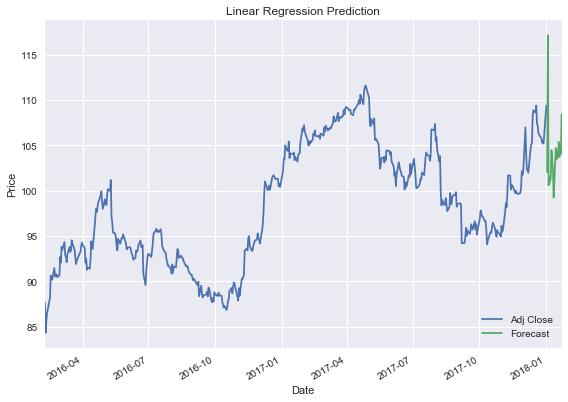

In [65]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

dfreg2 = dfreg.copy()

for i in forecast_poly3:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg2.loc[next_date] = [np.nan for _ in range(len(dfreg2.columns)-1)]+[i]
dfreg2['Adj Close'].tail(500).plot()
dfreg2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.title('Linear Regression Prediction')
plt.show()

## KNN

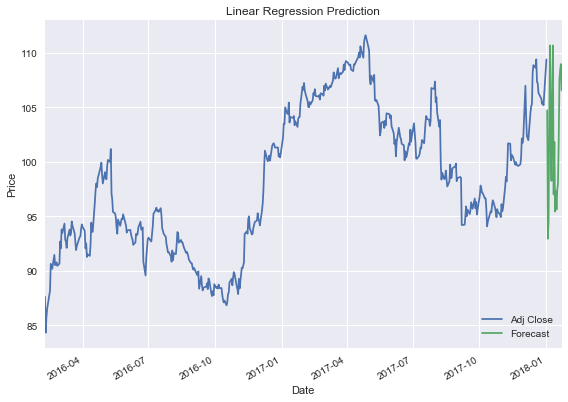

In [64]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

dfreg2 = dfreg.copy()

for i in forecast_knn:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg2.loc[next_date] = [np.nan for _ in range(len(dfreg2.columns)-1)]+[i]
dfreg2['Adj Close'].tail(500).plot()
dfreg2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.title('Linear Regression Prediction')
plt.show()